# SCANIA Component X Dataset: A Real-World Multivariate Time Series Dataset for Predictive Maintenance

## Data loading & paths

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

def resolve_base():
    env_dir = os.environ.get("DATA_DIR")
    if env_dir and Path(env_dir).expanduser().resolve().exists():
        return Path(env_dir).expanduser().resolve()
    cwd = Path.cwd().resolve()
    if any((cwd / nm).exists() for nm in ["train_specifications.csv","train_tte.csv"]):
        return cwd
    here = Path(__file__).parent if "__file__" in globals() else Path.cwd()
    data_dir = (here / "data").resolve()
    if data_dir.exists():
        return data_dir
    dl = Path.home() / "Downloads"
    if dl.exists():
        return dl.resolve()
    return cwd

BASE = resolve_base()
print("Using data directory:", BASE)

def req_csv(name: str) -> Path:
    p = BASE / name
    if not p.exists():
        raise FileNotFoundError(f"Required file not found: {p}\n"
                                f"• Put the file next to this notebook, or\n"
                                f"• Create a ./data folder, or\n"
                                f"• Set DATA_DIR to the folder with your files.")
    return p

SPEC_PATH = req_csv("train_specifications.csv")
TTE_PATH  = req_csv("train_tte.csv")

def load_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "vehicle_id" not in df.columns:
        for c in df.columns:
            if str(c).lower() in ("vehicle_id","vehicleid","truck_id","unit_id","id"):
                df = df.rename(columns={c:"vehicle_id"})
                break
        if "vehicle_id" not in df.columns:
            raise ValueError(f"Could not identify vehicle_id in {path.name}")
    return df

spec_df = load_csv(SPEC_PATH)
tte_df  = load_csv(TTE_PATH)

#Optional operational (histogramized) file
OP_CANDIDATES = [
    "train_operational_readouts.csv",
    "train_operational_readouts.parquet",
    "operational_readouts.csv",
    "train_operational.csv",
    "big_data.csv",
    "histogramized_operational.csv"
]
op_path = next((BASE / nm for nm in OP_CANDIDATES if (BASE / nm).exists()), None)
if op_path is not None and op_path.suffix.lower() == ".parquet":
    try:
        operational_df = pd.read_parquet(op_path)
    except Exception:
        operational_df = pd.read_csv(op_path.with_suffix(".csv")) if op_path.with_suffix(".csv").exists() else None
elif op_path is not None:
    operational_df = pd.read_csv(op_path)
else:
    operational_df = None

print("Loaded:")
print(" - specifications:", spec_df.shape, "from", SPEC_PATH.name)
print(" - tte:", tte_df.shape, "from", TTE_PATH.name)
print(" - operational:", None if operational_df is None else (operational_df.shape, "from", op_path.name))


Using data directory: C:\Users\W11\Desktop\DATA MINING\PROJECT
Loaded:
 - specifications: (23550, 9) from train_specifications.csv
 - tte: (23550, 3) from train_tte.csv
 - operational: ((1122452, 107), 'from', 'train_operational_readouts.csv')


## Aggregate operational readouts to vehicle level

In [11]:
#Build a vehicle-level dataset by aggregating operational time series.
import numpy as np
import pandas as pd

AGGREGATE = True  #If True, compute per-vehicle features from ALL time steps.

def per_vehicle_aggregate(df: pd.DataFrame) -> pd.DataFrame:

    """"
    Reduce time-series operational data to ONE ROW per vehicle.
    For each numeric column, compute:
      mean, std, min, max, median, last, and a simple OLS slope vs. row index.
    """
    #Identify numeric columns to aggregate.
    num_cols = [c for c in df.columns if c not in ("vehicle_id",) and np.issubdtype(df[c].dtype, np.number)]
    if not num_cols:
        return df.drop_duplicates("vehicle_id")

    #If a time-like column exists, sort within each vehicle first.
    time_candidates = ["time_step","timestep","time","readout_index"]
    tcol = next((c for c in time_candidates if c in df.columns), None)
    if tcol:
        df = df.sort_values(["vehicle_id", tcol])
    else:
        #No explicit time available- sort by vehicle only, row order acts as a proxy.
        df = df.sort_values(["vehicle_id"]).copy()

    #Distributional stats in one go
    agg_funcs = {c: ["mean","std","min","max","median","last"] for c in num_cols}
    dist = df.groupby("vehicle_id")[num_cols].agg(agg_funcs)
    dist.columns = [f"{col}_{stat}" for col, stat in dist.columns]

    #Trend (slope) per numeric feature using OLS vs. integer index.
    #we compute the OLS slope per numeric feature to capture the trend in each vehicle’s sensor readings over time.
    #the slope tells us whether those readings are increasing, decreasing, or stable on average, an indicator of degradation or wear that may precede failure.
    def slope(series):
        x = np.arange(len(series))
        y = series.values.astype(float)
        if len(y) < 2:
            return np.nan
        xm, ym = x.mean(), y.mean()
        denom = np.sum((x - xm) ** 2)
        return 0.0 if denom == 0 else np.sum((x - xm) * (y - ym)) / denom

    slopes = (df.groupby("vehicle_id")[num_cols]
                .apply(lambda d: pd.Series({f"{c}_slope": slope(d[c]) for c in num_cols})))

    out = dist.join(slopes, how="left").reset_index()
    return out

#Build the vehicle level base table
if operational_df is not None and AGGREGATE:
    #Ensure presence of the key column; normalize common aliases to 'vehicle_id'
    if "vehicle_id" not in operational_df.columns:
        for c in operational_df.columns:
            if str(c).lower() in ("vehicle_id","vehicleid","truck_id","unit_id","id"):
                operational_df = operational_df.rename(columns={c:"vehicle_id"})
                break
        if "vehicle_id" not in operational_df.columns:
            raise ValueError("Could not find vehicle_id in operational_df")

    agg_df = per_vehicle_aggregate(operational_df)
    print("Aggregated operational shape:", agg_df.shape)
else:
    #No operational data or aggregation disabled - continue with specs only.
    agg_df = None
    print("No operational aggregation (using specs only).")

#Merge specs + labels
if agg_df is None:
    base_df = spec_df.copy()
else:
    base_df = agg_df.merge(spec_df, on="vehicle_id", how="left")
#Attach outcomes/labels to the base feature table.
raw_merged = base_df.merge(tte_df, on="vehicle_id", how="left")
print("Merged shape:", raw_merged.shape)
print("Vehicles:", raw_merged["vehicle_id"].nunique())
print("Labels present:", [c for c in ["length_of_study_time_step","in_study_repair"] if c in raw_merged.columns])


Aggregated operational shape: (23550, 743)
Merged shape: (23550, 753)
Vehicles: 23550
Labels present: ['length_of_study_time_step', 'in_study_repair']


In [12]:
agg_df.head(3)

,vehicle_id,time_step_mean,time_step_std,time_step_min,time_step_max,time_step_median,time_step_last,171_0_mean,171_0_std,171_0_min,...,397_26_slope,397_27_slope,397_28_slope,397_29_slope,397_30_slope,397_31_slope,397_32_slope,397_33_slope,397_34_slope,397_35_slope
0,0,258.130233,148.787213,11.2,507.4,274.3,507.4,5.310002e+06,2.958805e+06,167985.0,...,22850.532800,1345.139013,246.662339,2.172823,213.555179,19811.216871,23482.075818,5404.486193,704.825745,1.895385
1,2,167.939394,80.951474,1.4,281.0,177.6,281.0,3.374853e+06,1.607343e+06,65520.0,...,69141.462567,4475.493316,642.193516,4.830214,501.831551,34666.067179,47628.890709,8893.321858,1356.959559,14.790107
2,3,131.608451,91.691168,0.2,291.2,136.6,291.2,3.274506e+06,2.474695e+06,1530.0,...,52536.002247,3994.253521,449.879041,3.043327,122.527632,11413.280483,42250.217404,8544.124413,1209.976761,9.289906


## Feature pruning: drop zero-bin aggregates & time-index features

Purpose: prune columns that aren’t useful for modeling or may leak indexing info:

Zero-bin aggregates like 123_0_mean: often represent a special bin (e.g., the first histogram bucket) that can dominate or be uninformative. We’re explicitly removing all stats derived from bin 0 only.

Aggregates of time columns (e.g., time_step_mean, time_step_slope): statistics of time itself carry no physical meaning for prediction and can leak sequence length/ordering rather than machine state.

Raw time columns (time_step, timestep, readout_index, time): same rationale remove direct time indices from the feature set.

In [13]:
#Drop aggregated time-index stats + ONLY *_0_* aggregated bin stats
import re
import pandas as pd

df = raw_merged.copy()

# Columns we must NEVER drop if present
protected = {"vehicle_id", "in_study_repair", "length_of_study_time_step"} & set(df.columns)

# Match EXACTLY the aggregated "zero-bin" columns to remove. (171_0_min/max/std/mean/median/last)
STAT_SUFFIXES = ("mean","std","min","max","median","last")
pattern_zero_bin = re.compile(rf"^\d+_0_({'|'.join(STAT_SUFFIXES)})$", re.IGNORECASE)
zero_bin_cols = [c for c in df.columns if c not in protected and pattern_zero_bin.match(c)]

# Aggregated time columns to remove (time_step_mean/std/min/max/median/last/slope)
time_bases = ("time_step", "timestep", "readout_index", "time")
time_stat_suffixes = STAT_SUFFIXES + ("slope",)
pattern_time_aggs = re.compile(
    rf"^({'|'.join(map(re.escape, time_bases))})_({'|'.join(time_stat_suffixes)})$",
    re.IGNORECASE
)
time_agg_cols = [c for c in df.columns if c not in protected and pattern_time_aggs.match(c)]

# Raw time cols just in case they exist un-aggregated
raw_time_cols = [c for c in df.columns if c.lower() in time_bases and c not in protected]

# Build final drop list
to_drop = sorted(set(zero_bin_cols + time_agg_cols + raw_time_cols) - protected)

# Preview before dropping
print(f"Matched *_0_* aggregated cols: {len(zero_bin_cols)}  (sample: {zero_bin_cols[:10]})")
print(f"Aggregated time cols: {len(time_agg_cols)}         (sample: {time_agg_cols[:10]})")
print(f"Raw time cols: {len(raw_time_cols)}                (list: {raw_time_cols})")

print(f"\nWill drop total {len(to_drop)} columns.")
print("Examples to drop:", to_drop[:20])

# Apply the drop; 'errors=\"ignore\"' avoids crashing if a listed column is missing
cleaned_merged = df.drop(columns=to_drop, errors="ignore")
print("Shapes: raw_merged ->", df.shape, " | cleaned_merged ->", cleaned_merged.shape)

# Continue downstream with the cleaned table
raw_merged = cleaned_merged


Matched *_0_* aggregated cols: 84  (sample: ['171_0_mean', '171_0_std', '171_0_min', '171_0_max', '171_0_median', '171_0_last', '666_0_mean', '666_0_std', '666_0_min', '666_0_max'])
Aggregated time cols: 7         (sample: ['time_step_mean', 'time_step_std', 'time_step_min', 'time_step_max', 'time_step_median', 'time_step_last', 'time_step_slope'])
Raw time cols: 0                (list: [])

Will drop total 91 columns.
Examples to drop: ['100_0_last', '100_0_max', '100_0_mean', '100_0_median', '100_0_min', '100_0_std', '158_0_last', '158_0_max', '158_0_mean', '158_0_median', '158_0_min', '158_0_std', '167_0_last', '167_0_max', '167_0_mean', '167_0_median', '167_0_min', '167_0_std', '171_0_last', '171_0_max']
Shapes: raw_merged -> (23550, 753)  | cleaned_merged -> (23550, 662)


In [14]:
cleaned_merged.head(3)

,vehicle_id,167_1_mean,167_1_std,167_1_min,167_1_max,167_1_median,167_1_last,167_2_mean,167_2_std,167_2_min,...,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7,length_of_study_time_step,in_study_repair
0,0,1.299638e+06,4.550232e+03,1296420.0,1302855.0,1299637.5,1302855.0,1.628265e+06,0.000000e+00,1628265.0,...,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,510.0,0
1,2,5.423560e+06,2.390315e+06,811605.0,9137870.0,5571347.0,9137870.0,4.780749e+07,2.154369e+07,1644061.0,...,Cat0,Cat1,Cat1,Cat0,Cat0,Cat0,Cat0,Cat1,281.8,0
2,3,4.003922e+06,2.735321e+06,178155.0,8225139.0,4383337.0,8225139.0,8.405528e+06,5.684231e+06,137220.0,...,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1,293.4,0


## Preprocessing: impute, scale, one-hot, and get feature names

In [15]:

import numpy as np, pandas as pd
from inspect import signature
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("sklearn:", __import__("sklearn").__version__)

df = raw_merged.copy()
#Pick available label columns
label_cols = [c for c in ["length_of_study_time_step","in_study_repair"] if c in df.columns]
y = df[label_cols].copy() if label_cols else None
#Features = everything except labels and the vehicle identifier
X = df.drop(columns=[c for c in label_cols] + ["vehicle_id"], errors="ignore")

#Split features by dtype for separate pipelines
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

def build_ohe():
    params = signature(OneHotEncoder).parameters
    if "sparse_output" in params:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    elif "sparse" in params:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)
    else:
        return OneHotEncoder(handle_unknown="ignore")

ohe = build_ohe()

#Numeric pipeline: impute missing with median, then standardize
numeric_pipeline = Pipeline([("imp", SimpleImputer(strategy="median")),
                             ("sc", StandardScaler())])
#Categorical pipeline: impute most frequent, then one-hot encode
categorical_pipeline = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                                 ("oh", ohe)])
#Column-wise preprocessing: apply the right pipeline to each column subset
preprocess = ColumnTransformer([("num", numeric_pipeline, num_cols),
                                ("cat", categorical_pipeline, cat_cols)])


# Fit the preprocessors on X and transform to a model-ready matrix
X_pre = preprocess.fit_transform(X)

#If the result is sparse, convert to dense
try:
    from scipy import sparse as sp
    if sp.issparse(X_pre):
        X_pre = X_pre.toarray()
except Exception:
    pass

# Recover categorical feature names after one-hot expansion for interpretability
enc = preprocess.named_transformers_["cat"].named_steps["oh"]
if cat_cols:
    if hasattr(enc, "get_feature_names_out"):
        cat_feature_names = enc.get_feature_names_out(cat_cols).tolist()
    else:
        cat_feature_names = []
        for c, cats in zip(cat_cols, enc.categories_):
            cat_feature_names += [f"{c}_{val}" for val in cats]
else:
    cat_feature_names = []

#Final feature name list = original numeric columns + expanded categorical names
feature_names = list(num_cols) + cat_feature_names
print("X_pre shape:", X_pre.shape, "| numeric:", len(num_cols), "| cat (expanded):", len(cat_feature_names))


sklearn: 1.7.2
X_pre shape: (23550, 741) | numeric: 651 | cat (expanded): 90


## PCA for dimensionality reduction (≥95% variance) + visuals

PCA components kept for ≥95% variance: 74/741


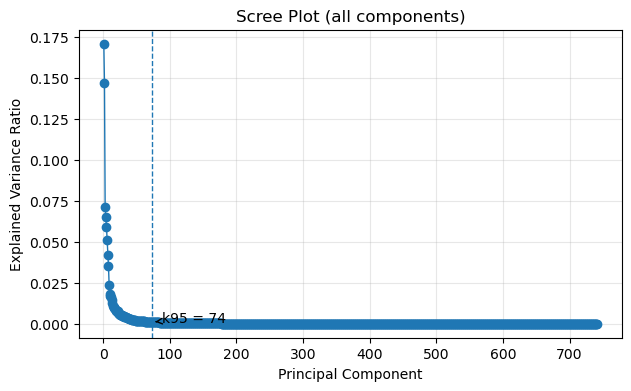

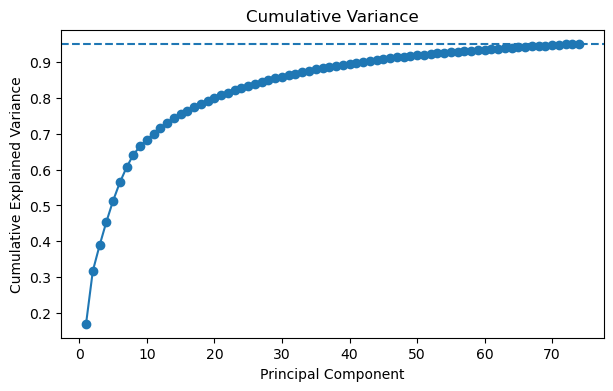

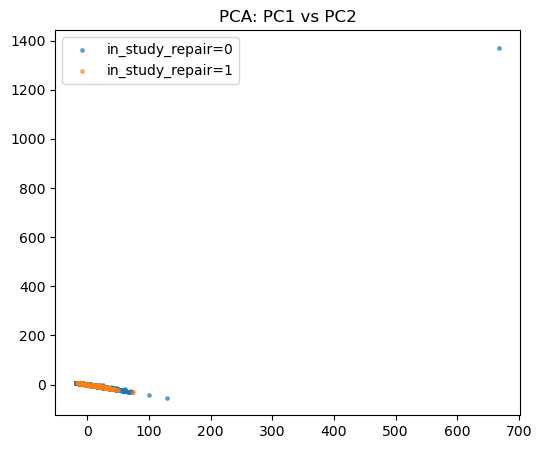

,feature,abs_loading
0,158_6_mean,0.077262
1,158_6_median,0.076452
2,158_6_last,0.076130
3,158_6_max,0.076130
4,158_6_std,0.075021
5,158_5_mean,0.074989
6,459_10_mean,0.074564
7,459_11_mean,0.074419
8,459_12_mean,0.074139
9,158_5_median,0.074124


,feature,abs_loading
0,397_23_std,0.092852
1,397_23_slope,0.092852
2,397_23_last,0.092852
3,397_23_max,0.092852
4,397_23_mean,0.092850
5,397_11_std,0.092849
6,397_11_slope,0.092849
7,397_11_max,0.092848
8,397_11_last,0.092848
9,397_28_std,0.092845


In [16]:

# --- PCA (retain ≥95% variance) + inline visuals ---
import numpy as np, pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1) Fit a full PCA to learn explained-variance ratios for ALL components
pca_full = PCA().fit(X_pre)
cumulative = np.cumsum(pca_full.explained_variance_ratio_)
# 2) Smallest k such that cumulative variance ≥ 0.95
k95 = int(np.searchsorted(cumulative, 0.95) + 1)

# 3) Fit PCA again restricted to the first k95 components and transform X
#    (keeps dimensionality just large enough to explain ≥95% of total variance)
pca = PCA(n_components=k95).fit(X_pre)
X_pca = pca.transform(X_pre)
print(f"PCA components kept for ≥95% variance: {k95}/{X_pre.shape[1]}")

#----------VISUAL CHECKS----------

# Scree plot (FULL PCs) with 95% cutoff marker
# Assumes `pca_full` (fit on all components) and `k95` are already defined.
fig, ax = plt.subplots(figsize=(7,4))
evr_full = pca_full.explained_variance_ratio_

ax.plot(np.arange(1, len(evr_full) + 1), evr_full, marker="o", linewidth=1)
ax.axvline(k95, linestyle="--", linewidth=1)
ax.annotate(f"k95 = {k95}", xy=(k95, evr_full[k95-1]),
            xytext=(k95 + max(3, len(evr_full)//50), evr_full[k95-1]),
            arrowprops=dict(arrowstyle="->", lw=1))

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("Scree Plot (all components)")
ax.grid(alpha=0.3)
plt.show()

# Cumulative
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker="o")
ax.axhline(0.95, linestyle="--")
ax.set_xlabel("Principal Component"); ax.set_ylabel("Cumulative Explained Variance"); ax.set_title("Cumulative Variance")
plt.show()

# PC1 vs PC2
pc_df = pd.DataFrame(X_pca[:, :2], columns=["PC1","PC2"])
if 'y' in globals() and y is not None and "in_study_repair" in y.columns:
    pc_df["label"] = y["in_study_repair"].values
else:
    pc_df["label"] = 0

fig, ax = plt.subplots(figsize=(6,5))
for lbl in sorted(pc_df["label"].unique()):
    pts = pc_df[pc_df["label"]==lbl]
    ax.scatter(pts["PC1"], pts["PC2"], s=6, label=f"in_study_repair={lbl}", alpha=0.6)
ax.legend(); ax.set_title("PCA: PC1 vs PC2"); plt.show()

# Top loadings
loadings = pd.DataFrame(pca.components_, columns=feature_names)
def top_loadings(loadings_df, pc_idx=0, topk=15):
    pc = loadings_df.iloc[pc_idx].abs().sort_values(ascending=False)
    return pd.DataFrame({"feature": pc.index[:topk], "abs_loading": pc.values[:topk]})
display(top_loadings(loadings, pc_idx=0, topk=15))
display(top_loadings(loadings, pc_idx=1, topk=15))


PCA OUTCOMES

1- We can compress ~700+ features down to ~74 PCs with minimal information loss—good for speed and de-noising.

2- PCA is unsupervised, so PC1/PC2 don’t separate the label much. The model will still learn on the full feature (or PC) set with supervision.

3- A handful of sensor/bins (e.g., 158, 459 for PC1; 397 for PC2) explain most variance. Our slope features show up among top PC2 loadings, which means trends matter.

4- Those few far-out points are likely outliers.

## Optimized label-focused association rules (FP-Growth)

OPTIMIZED ASSOCIATION RULE MINING
Initial basket: 23550 tx × 1361 items
After pruning rare items (<5.0% support): 1294 items
Computing correlations with LABEL_REPAIR_1...


c:\Users\W11\anaconda3\envs\DS_ENV\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\W11\anaconda3\envs\DS_ENV\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


After keeping top-100 correlated items: 103 items

Final basket size: 23550 transactions × 103 items
Label target: LABEL_REPAIR_1
Label support: 9.65%

Mining frequent itemsets with FP-Growth...
Parameters: min_support=0.15, max_len=3
 Found 49209 frequent itemsets

Generating association rules (min_confidence=0.6)...
 Generated 181749 rules
 Filtered to 2279 label-predicting rules (from 181749)

TOP 25 ASSOCIATION RULES (sorted by lift)


,antecedents_str,consequents_str,support,confidence,lift
86095,"158_6_max_(8100.999, 7323236.0], 397_26_slope_...","LABEL_LENGTH_(73.399, 218.2]",0.153715,0.921120,1.838648
86102,"158_6_last_(8100.999, 7323236.0], 397_26_slope...","LABEL_LENGTH_(73.399, 218.2]",0.153715,0.921120,1.838648
171421,"158_6_max_(8100.999, 7323236.0], 167_6_slope_(...","LABEL_LENGTH_(73.399, 218.2]",0.161359,0.915663,1.827755
171430,"158_6_last_(8100.999, 7323236.0], 167_6_slope_...","LABEL_LENGTH_(73.399, 218.2]",0.161359,0.915663,1.827755
90266,"158_6_max_(8100.999, 7323236.0], 158_8_slope_(...","LABEL_LENGTH_(73.399, 218.2]",0.154607,0.912303,1.821048
90273,"158_6_last_(8100.999, 7323236.0], 158_8_slope_...","LABEL_LENGTH_(73.399, 218.2]",0.154607,0.912303,1.821048
86092,"158_6_mean_(2645.832, 3877388.594], 397_26_slo...","LABEL_LENGTH_(73.399, 218.2]",0.153461,0.908268,1.812996
171444,"158_6_std_(1674.448, 2155368.486], 167_6_slope...","LABEL_LENGTH_(73.399, 218.2]",0.155499,0.907109,1.810682
48833,"158_6_slope_(601.899, 178033.964], 158_6_std_(...","LABEL_LENGTH_(218.2, 510.0]",0.150998,0.902996,1.809527
171414,"158_6_mean_(2645.832, 3877388.594], 167_6_slop...","LABEL_LENGTH_(73.399, 218.2]",0.161444,0.896275,1.789056



TOP 15 RULES IN READABLE FORMAT


,rule
86095,"If [158_6_max_(8100.999, 7323236.0], 397_26_sl..."
86102,"If [158_6_last_(8100.999, 7323236.0], 397_26_s..."
171421,"If [158_6_max_(8100.999, 7323236.0], 167_6_slo..."
171430,"If [158_6_last_(8100.999, 7323236.0], 167_6_sl..."
90266,"If [158_6_max_(8100.999, 7323236.0], 158_8_slo..."
90273,"If [158_6_last_(8100.999, 7323236.0], 158_8_sl..."
86092,"If [158_6_mean_(2645.832, 3877388.594], 397_26..."
171444,"If [158_6_std_(1674.448, 2155368.486], 167_6_s..."
48833,"If [158_6_slope_(601.899, 178033.964], 158_6_s..."
171414,"If [158_6_mean_(2645.832, 3877388.594], 167_6_..."



Generating rule graph...


C:\Users\W11\AppData\Local\Temp\ipykernel_11936\3466509610.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


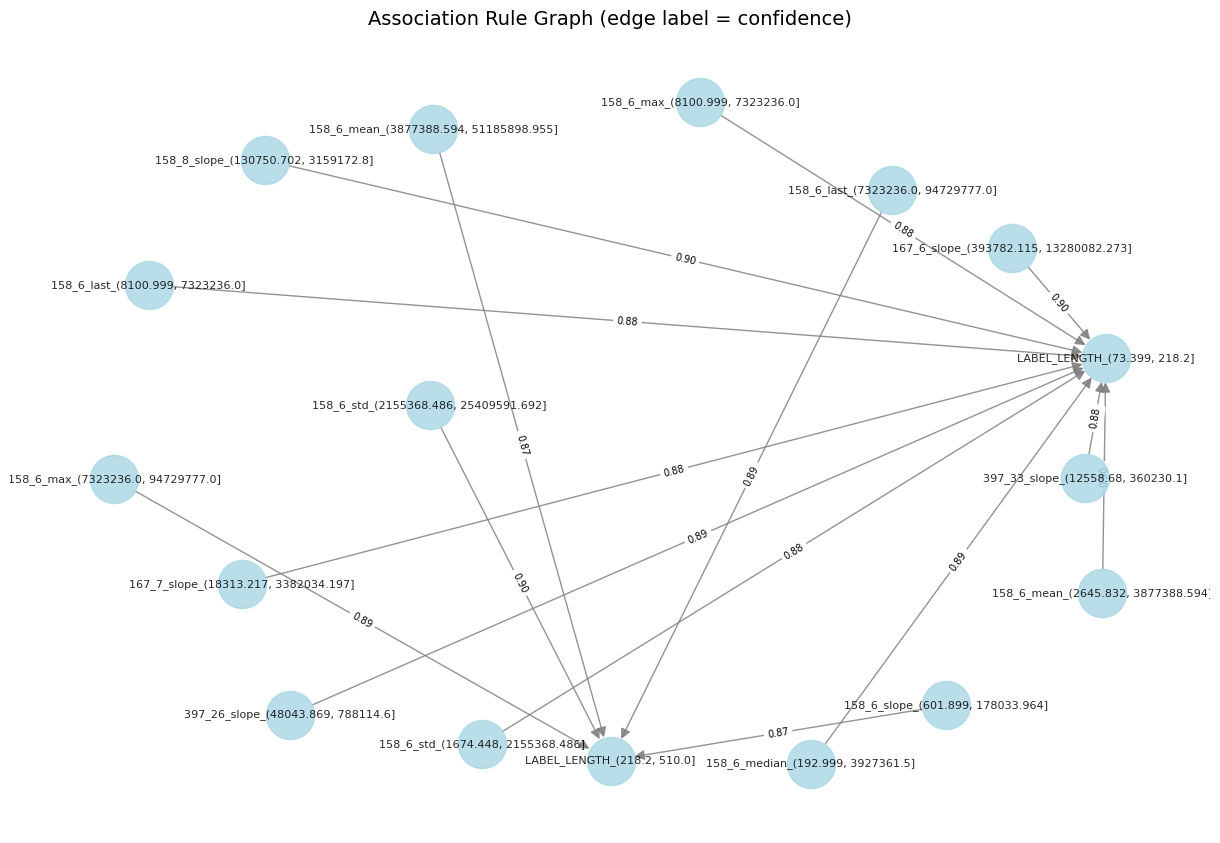


DONE


In [18]:
# Faster version with reduced item space for quicker execution

import numpy as np, pandas as pd
from pathlib import Path

# Tunables (OPTIMIZED FOR SPEED)
Q = 2                       # quantile bins for numerics (2 is fast)
MIN_ITEM_SUPPORT = 0.05     # drop items seen in <5% of vehicles (INCREASED from 0.02)
MIN_SUPPORT = 0.15          # frequent itemset support (INCREASED from 0.12)
MIN_CONFIDENCE = 0.60       # rule confidence threshold (LOWERED from 0.70)
TOP_N_BY_LABEL = 100        # keep top-100 items by correlation (REDUCED from 400)
LABEL_TARGET = "auto"       # "auto" picks LABEL_REPAIR_1 or most frequent LABEL_LENGTH_* bin
MAX_LEN = 3                 # max itemset length for speed


print("=" * 60)
print("OPTIMIZED ASSOCIATION RULE MINING")
print("=" * 60)

# ---------- Build basket (binarized) ----------
def discretize_numeric(df, cols, q=Q):
    out = {}
    for c in cols:
        s = df[c]
        try:
            bins = pd.qcut(s, q=q, duplicates="drop")
            out[c] = bins.astype(str)
        except Exception:
            out[c] = pd.Series(["bin_all"]*len(df), index=df.index)
    return pd.DataFrame(out, index=df.index)

# Features only (drop labels/id)
X_raw = raw_merged.drop(columns=[c for c in ["in_study_repair","length_of_study_time_step","vehicle_id"]
                                 if c in raw_merged.columns], errors="ignore")

# Type split
cat_cols = [c for c in X_raw.columns if X_raw[c].dtype == "object"]
num_cols = [c for c in X_raw.columns if c not in cat_cols]

# Simple imputation
X_imp = X_raw.copy()
for c in num_cols:
    if X_imp[c].isna().any():
        X_imp[c] = X_imp[c].fillna(X_imp[c].median())
for c in cat_cols:
    if X_imp[c].isna().any():
        X_imp[c] = X_imp[c].fillna("Missing")

# One-hot categorical + discretized numerics
cat_onehot = pd.get_dummies(X_imp[cat_cols], prefix=cat_cols, drop_first=False) if cat_cols else pd.DataFrame(index=X_imp.index)
num_binned = discretize_numeric(X_imp, num_cols, q=Q) if num_cols else pd.DataFrame(index=X_imp.index)
num_onehot = pd.get_dummies(num_binned, prefix=num_cols, drop_first=False) if not num_binned.empty else pd.DataFrame(index=X_imp.index)

# Label items
label_items = pd.DataFrame(index=X_imp.index)
if "in_study_repair" in raw_merged.columns:
    label_items["LABEL_REPAIR_1"] = (raw_merged["in_study_repair"] == 1).astype(int)
if "length_of_study_time_step" in raw_merged.columns:
    try:
        bins = pd.qcut(raw_merged["length_of_study_time_step"], q=Q, duplicates="drop").astype(str)
    except Exception:
        bins = pd.Series(["LENGTH_all"]*len(raw_merged), index=raw_merged.index)
    label_items = pd.concat([label_items, pd.get_dummies(bins, prefix="LABEL_LENGTH", drop_first=False)], axis=1)

# Final basket
basket = pd.concat([cat_onehot, num_onehot, label_items], axis=1).astype(int)
basket = basket.loc[:, basket.sum(axis=0) > 0]  # drop empty columns
print(f"Initial basket: {basket.shape[0]} tx × {basket.shape[1]} items")

# ---------- Pre-prune (rare items) ----------
item_support = basket.mean(axis=0)
keep_items = item_support[item_support >= MIN_ITEM_SUPPORT].index
basket = basket[keep_items]
item_support = item_support.loc[keep_items]
print(f"After pruning rare items (<{MIN_ITEM_SUPPORT*100}% support): {basket.shape[1]} items")

# ---------- Keep top-N items most associated with label ----------
label_cols_items = [c for c in basket.columns if c.startswith("LABEL_")]
if LABEL_TARGET == "auto":
    if "LABEL_REPAIR_1" in label_cols_items:
        target = "LABEL_REPAIR_1"
    else:
        # pick most frequent length bin
        length_bins = [c for c in label_cols_items if c.startswith("LABEL_LENGTH_")]
        target = pd.Series(basket[length_bins].mean()).idxmax() if length_bins else None
else:
    target = LABEL_TARGET if LABEL_TARGET in basket.columns else None

if target and TOP_N_BY_LABEL is not None:
    y = basket[target].astype(int)
    non_label_cols = [c for c in basket.columns if not c.startswith("LABEL_")]
    # proxy relevance by absolute correlation with label (binary y)
    print(f"Computing correlations with {target}...")
    corrs = basket[non_label_cols].astype(int).corrwith(y).abs().sort_values(ascending=False)
    # Remove NaN correlations (constant columns)
    corrs = corrs[~corrs.isna()]
    keep_top = corrs.head(TOP_N_BY_LABEL).index.tolist()
    basket = basket[keep_top + label_cols_items]
    print(f"After keeping top-{TOP_N_BY_LABEL} correlated items: {basket.shape[1]} items")

# Ensure strictly boolean for fp-growth
basket_bool = basket.astype(bool)

print(f"\nFinal basket size: {basket_bool.shape[0]} transactions × {basket_bool.shape[1]} items")
print(f"Label target: {target}")
print(f"Label support: {basket_bool[target].mean():.2%}" if target in basket_bool.columns else "")
print("\n" + "=" * 60)

# ---------- FP-Growth mining (fast) ----------
print("Mining frequent itemsets with FP-Growth...")
print(f"Parameters: min_support={MIN_SUPPORT}, max_len={MAX_LEN}")

try:
    from mlxtend.frequent_patterns import fpgrowth, association_rules
except Exception as e:
    raise RuntimeError("mlxtend is required for FP-Growth. Install with: pip install mlxtend") from e

try:
    freq = fpgrowth(basket_bool, min_support=MIN_SUPPORT, use_colnames=True, max_len=MAX_LEN)
    print(f" Found {len(freq)} frequent itemsets")
except Exception as e:
    print(f" FP-Growth failed: {e}")
    print("\nTrying Apriori as fallback...")
    from mlxtend.frequent_patterns import apriori
    freq = apriori(basket_bool, min_support=MIN_SUPPORT, use_colnames=True, max_len=MAX_LEN)
    print(f" Found {len(freq)} frequent itemsets with Apriori")

if freq.empty:
    print("\nNo frequent itemsets found!")
    print("Suggestions:")
    print(f"  - Lower MIN_SUPPORT (currently {MIN_SUPPORT})")
    print(f"  - Lower MIN_ITEM_SUPPORT (currently {MIN_ITEM_SUPPORT})")
    print(f"  - Increase TOP_N_BY_LABEL (currently {TOP_N_BY_LABEL})")
else:
    print(f"\nGenerating association rules (min_confidence={MIN_CONFIDENCE})...")
    rules = association_rules(freq, metric="confidence", min_threshold=MIN_CONFIDENCE)
    print(f" Generated {len(rules)} rules")
    
    # Filter: keep only rules predicting labels (more interpretable)
    if label_cols_items:
        rules_before = len(rules)
        rules = rules[rules["consequents"].apply(lambda s: all(c in label_cols_items for c in list(s)))]
        print(f" Filtered to {len(rules)} label-predicting rules (from {rules_before})")
    
    if rules.empty:
        print("\nNo rules predicting labels found!")
        print("Suggestions:")
        print(f"  - Lower MIN_CONFIDENCE (currently {MIN_CONFIDENCE})")
        print(f"  - Check if label items are in frequent itemsets")
    else:
        # Tidy output
        def set_to_str(x): return ", ".join(sorted(list(x))) if hasattr(x, "__iter__") else str(x)
        rules = (rules
            .assign(antecedents_str = rules["antecedents"].apply(set_to_str),
                    consequents_str = rules["consequents"].apply(set_to_str))
            .sort_values(["lift","confidence","support"], ascending=False)
                 )
        
        # Show compact table
        print("\n" + "=" * 60)
        print("TOP 25 ASSOCIATION RULES (sorted by lift)")
        print("=" * 60)
        cols = ["antecedents_str","consequents_str","support","confidence","lift"]
        display(rules[cols].head(25))

        # Human-readable text lines
        print("\n" + "=" * 60)
        print("TOP 15 RULES IN READABLE FORMAT")
        print("=" * 60)
        def rule_text(row):
            return f"If [{row['antecedents_str']}] then [{row['consequents_str']}]  " \
                   f"(support={row['support']:.2%}, conf={row['confidence']:.2%}, lift={row['lift']:.2f})"
        rules_text = rules.head(15).apply(rule_text, axis=1).to_frame("rule")
        display(rules_text)

        # Optional: small graph (if networkx is available)
        try:
            import networkx as nx
            import matplotlib.pyplot as plt
            
            print("\nGenerating rule graph...")
            rsmall = rules.head(20)
            G = nx.DiGraph()
            for _, r in rsmall.iterrows():
                A = r["antecedents"]; C = r["consequents"]
                for a in A: 
                    for c in C:
                        G.add_edge(a, c, conf=float(r["confidence"]), lift=float(r["lift"]))
            
            plt.figure(figsize=(12,8))
            pos = nx.spring_layout(G, seed=42, k=2, iterations=50)
            nx.draw(G, pos, with_labels=True, node_size=1200, alpha=0.85, 
                   font_size=8, node_color='lightblue', edge_color='gray', 
                   arrows=True, arrowsize=15)
            edge_lbl = {(u,v): f"{d['conf']:.2f}" for u,v,d in G.edges(data=True)}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_lbl, font_size=7)
            plt.title("Association Rule Graph (edge label = confidence)", fontsize=14)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Graph visualization skipped: {e}")

print("\n" + "=" * 60)
print("DONE")
print("=" * 60)

## Association rule network (readable labels, confidence & lift)

ASSOCIATION RULE GRAPH


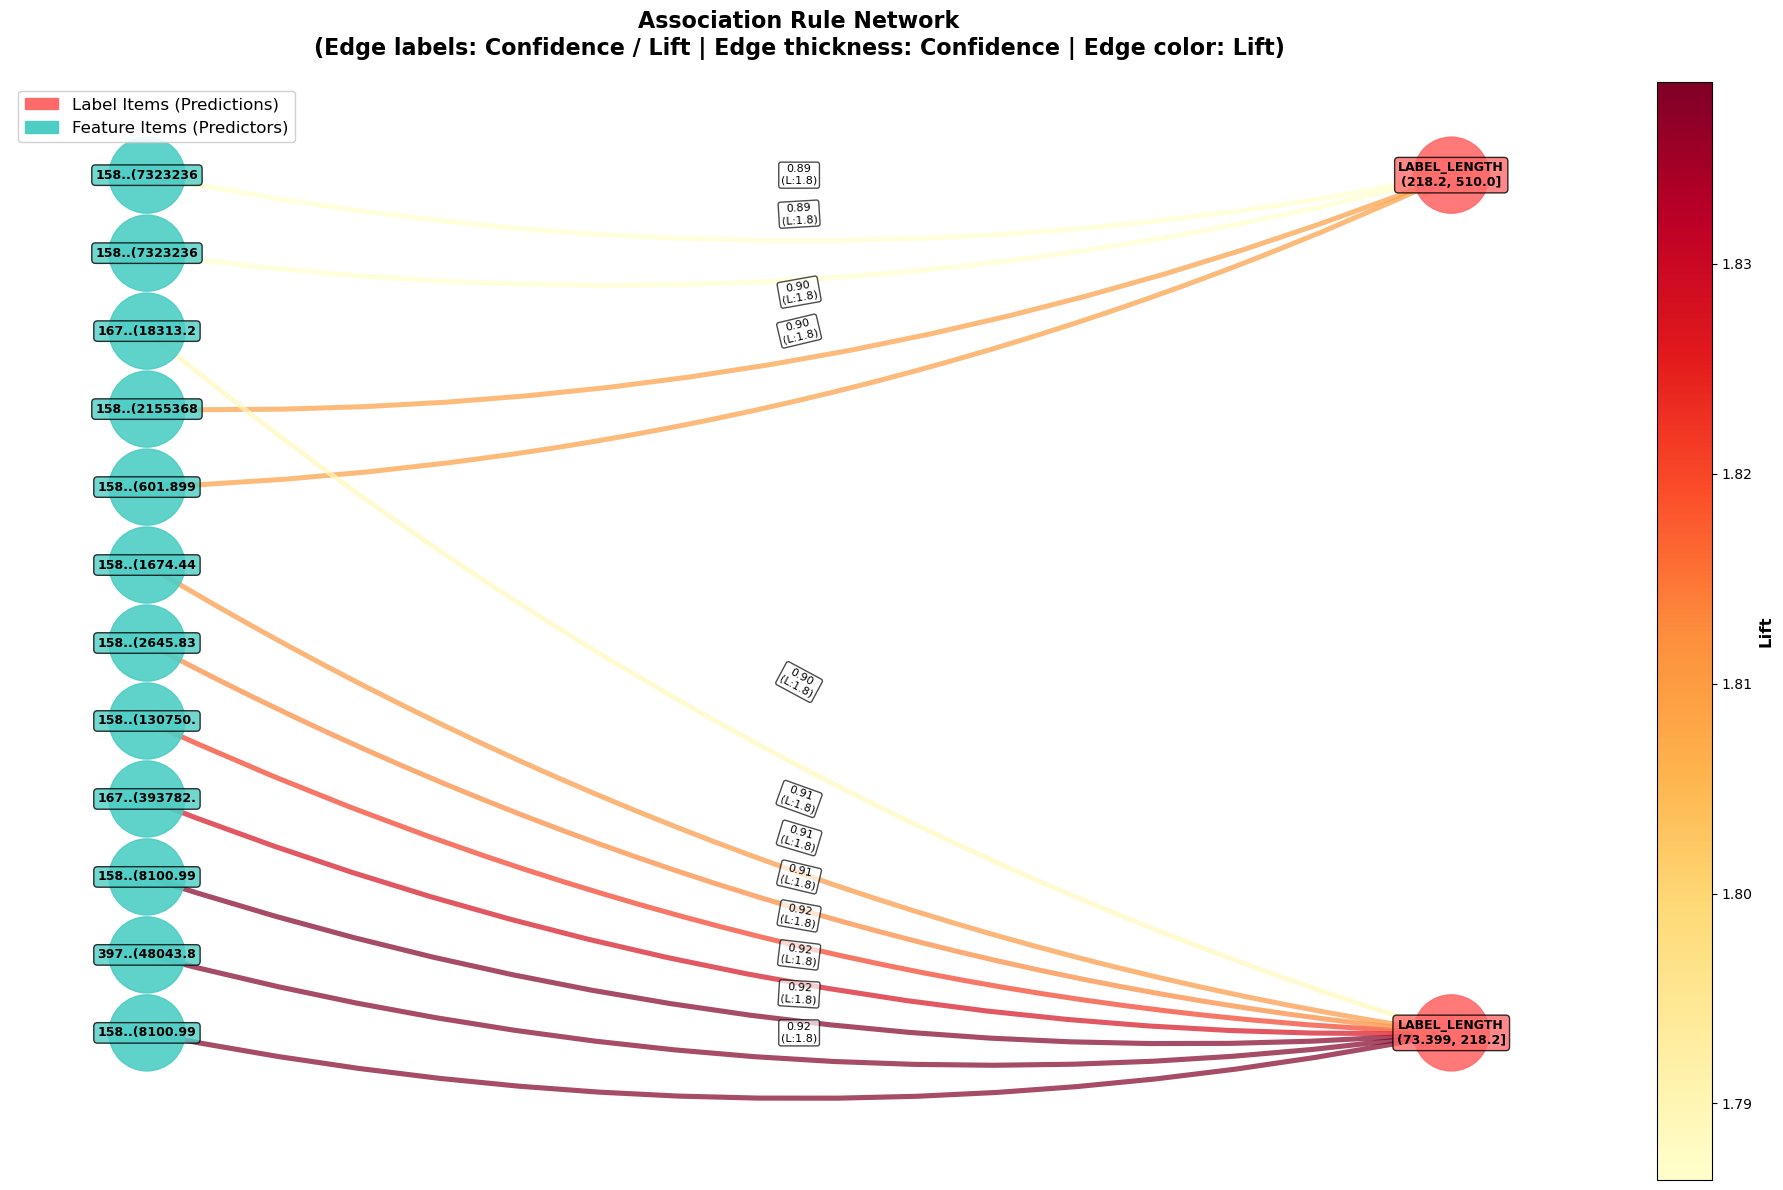


 Visualization Guide:
   Red nodes = Label items (what we're predicting)
   Teal nodes = Feature items (what predicts the labels)
   Edge thickness = Confidence strength (thicker = higher confidence)
   Edge color = Lift value (darker red = higher lift)
   Arrow direction = IF feature THEN label

 Showing top 15 rules for readability


In [19]:
# Improved Rule graph with better label formatting

try:
    import networkx as nx
    import matplotlib.pyplot as plt
    from matplotlib import patches

    if 'rules' in globals() and rules is not None and len(rules):
        print("=" * 60)
        print("ASSOCIATION RULE GRAPH")
        print("=" * 60)

        def to_tuple(x):
            if isinstance(x, (set, frozenset)): return tuple(sorted(x))
            if hasattr(x, "tolist"): return tuple(sorted(x.tolist()))
            if isinstance(x, tuple): return x
            if isinstance(x, list): return tuple(sorted(x))
            return (str(x),)

        def shorten_label(s, max_len=30):
            """Shorten long labels for readability"""
            if len(s) <= max_len:
                return s
            # Try to abbreviate intelligently
            parts = s.split('_')
            if len(parts) > 3:
                return f"{parts[0]}..{parts[-1][:8]}"
            return s[:max_len-3] + "..."

        rules_small = rules.head(15).copy()
        G = nx.DiGraph()
        node_labels = {}

        for _, r in rules_small.iterrows():
            A = to_tuple(r.get("antecedents", r.get("antecedent")))
            C = to_tuple(r.get("consequents", r.get("consequent")))
            conf = float(r["confidence"])
            lift_val = float(r["lift"]) if not np.isnan(r["lift"]) else 1.0

            for a in A:
                for c in C:
                    # Only add edge if not already present or if this has higher confidence
                    if G.has_edge(a, c):
                        if conf > G[a][c]['conf']:
                            G[a][c]['conf'] = conf
                            G[a][c]['lift'] = lift_val
                    else:
                        G.add_edge(a, c, conf=conf, lift=lift_val)
                    
                    # Store shortened labels
                    node_labels[a] = shorten_label(str(a))
                    node_labels[c] = shorten_label(str(c))

        # Create figure with better layout
        fig, ax = plt.subplots(figsize=(18, 12))

        # Use hierarchical layout for better visualization
        try:
            # Try to separate label and feature nodes
            label_nodes = [n for n in G.nodes() if 'LABEL_' in str(n)]
            feature_nodes = [n for n in G.nodes() if 'LABEL_' not in str(n)]
            
            # Create position manually for better layout
            pos = {}
            # Place label nodes on the right
            for i, node in enumerate(label_nodes):
                pos[node] = (1.5, i * (2.0 / max(1, len(label_nodes)-1)) - 1.0 if len(label_nodes) > 1 else 0)
            # Place feature nodes on the left
            for i, node in enumerate(feature_nodes):
                pos[node] = (-1.5, i * (2.0 / max(1, len(feature_nodes)-1)) - 1.0 if len(feature_nodes) > 1 else 0)
        except:
            pos = nx.spring_layout(G, seed=42, k=2, iterations=100)

        # Color nodes by type (label vs feature)
        node_colors = []
        for node in G.nodes():
            if 'LABEL_' in str(node):
                node_colors.append('#ff6b6b')  # Red for labels
            else:
                node_colors.append('#4ecdc4')  # Teal for features

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                              node_size=3000, alpha=0.9, ax=ax,
                              node_shape='o')

        # Draw edges with varying thickness based on confidence
        edges = G.edges()
        weights = [G[u][v]['conf'] * 4 for u, v in edges]  # Scale for visibility
        edge_colors = [G[u][v]['lift'] for u, v in edges]  # Color by lift
        
        # Create colormap for lift values
        import matplotlib.cm as cm
        import matplotlib.colors as mcolors
        norm = mcolors.Normalize(vmin=min(edge_colors), vmax=max(edge_colors))
        cmap = cm.YlOrRd
        
        edges_collection = nx.draw_networkx_edges(
            G, pos, width=weights, alpha=0.7,
            edge_color=edge_colors, edge_cmap=cmap, edge_vmin=min(edge_colors),
            edge_vmax=max(edge_colors), arrows=True, arrowsize=25,
            ax=ax, arrowstyle='-|>', connectionstyle='arc3,rad=0.1'
        )

        # Draw labels with better positioning and wrapping
        for node, (x, y) in pos.items():
            label = node_labels[node]
            # Wrap long labels
            if len(label) > 20:
                words = label.split('_')
                if len(words) > 2:
                    label = '_'.join(words[:2]) + '\n' + '_'.join(words[2:])
            
            ax.text(x, y, label, fontsize=9, fontweight='bold',
                   ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', 
                           facecolor=node_colors[list(G.nodes()).index(node)],
                           edgecolor='black', alpha=0.8))

        # Draw edge labels (confidence and lift) with better positioning
        edge_labels = {}
        for u, v, d in G.edges(data=True):
            edge_labels[(u, v)] = f"{d['conf']:.2f}\n(L:{d['lift']:.1f})"
        
        nx.draw_networkx_edge_labels(
            G, pos, edge_labels=edge_labels, font_size=8,
            ax=ax, bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7)
        )

        # Add colorbar for lift values
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Lift', fontsize=12, fontweight='bold')

        # Add legend
        red_patch = patches.Patch(color='#ff6b6b', label='Label Items (Predictions)')
        teal_patch = patches.Patch(color='#4ecdc4', label='Feature Items (Predictors)')
        ax.legend(handles=[red_patch, teal_patch], loc='upper left', fontsize=12, framealpha=0.9)

        plt.title("Association Rule Network\n(Edge labels: Confidence / Lift | Edge thickness: Confidence | Edge color: Lift)",
                 fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        print("\n Visualization Guide:")
        print("   Red nodes = Label items (what we're predicting)")
        print("   Teal nodes = Feature items (what predicts the labels)")
        print("   Edge thickness = Confidence strength (thicker = higher confidence)")
        print("   Edge color = Lift value (darker red = higher lift)")
        print("   Arrow direction = IF feature THEN label")
        print("\n Showing top 15 rules for readability")
    else:
        print("No rules to visualize.")
except Exception as e:
    print("Graph visualization skipped:", e)
    import traceback
    traceback.print_exc()

## Numeric → Binary demo (median split)

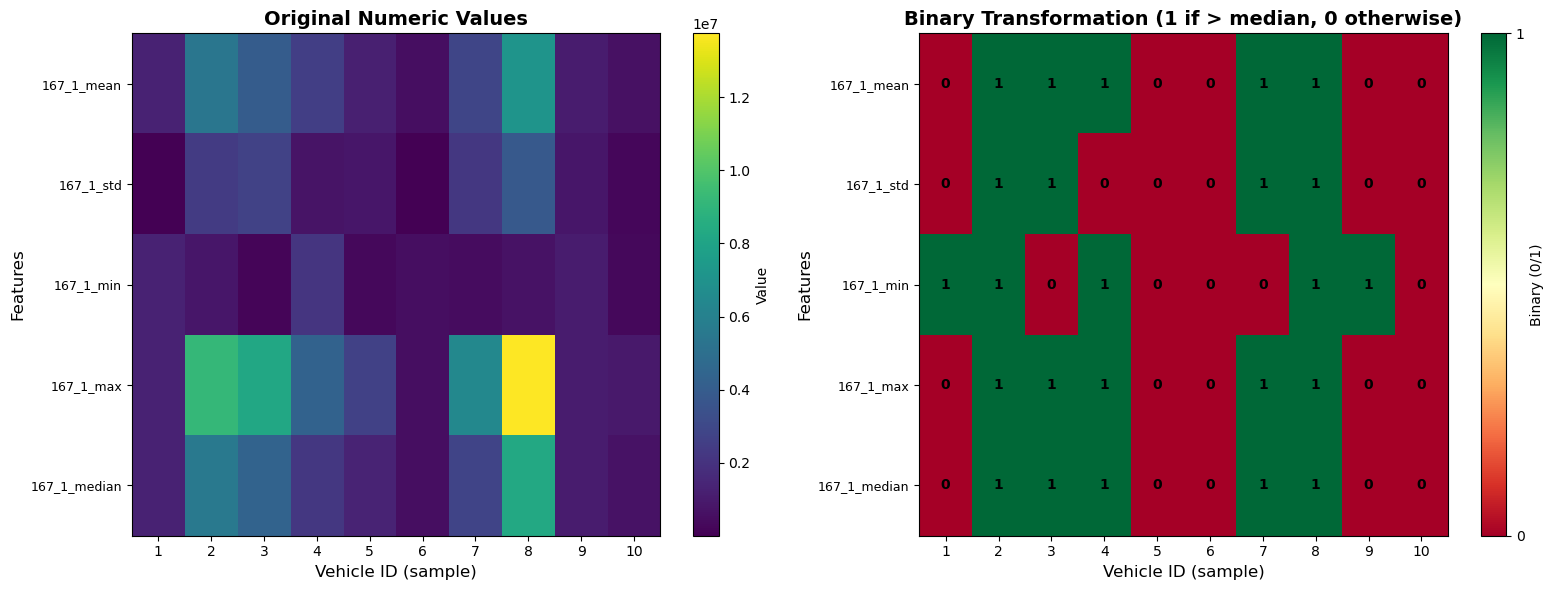


NUMERIC-TO-BINARY TRANSFORMATION SUMMARY

 Original Data (first 5 vehicles):
     167_1_mean     167_1_std  167_1_min  167_1_max  167_1_median
0  1.299638e+06  4.550232e+03  1296420.0  1302855.0     1299637.5
1  5.423560e+06  2.390315e+06   811605.0  9137870.0     5571347.0
2  4.003922e+06  2.735321e+06   178155.0  8225139.0     4383337.0
3  2.555733e+06  7.465466e+05  2115617.0  4342398.0     2245705.5
4  1.226105e+06  8.419111e+05   323910.0  2640436.0     1390035.5

 Binary Transformed Data (first 5 vehicles):
   167_1_mean  167_1_std  167_1_min  167_1_max  167_1_median
0           0          0          1          0             0
1           1          1          1          1             1
2           1          1          0          1             1
3           1          0          1          1             1
4           0          0          0          0             0

 Transformation rule: 1 if value > median, else 0
 Median values:
  • 167_1_mean: 1927685.19
  • 167_1_std: 84191

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example: Show transformation of continuous features to binary
if 'raw_merged' in globals():
    # Select a few numeric columns as examples
    numeric_cols = [c for c in raw_merged.columns 
                    if c not in ['vehicle_id', 'in_study_repair', 'length_of_study_time_step'] 
                    and np.issubdtype(raw_merged[c].dtype, np.number)]
    
    # Pick first 5 numeric columns for demonstration
    sample_cols = numeric_cols[:5] if len(numeric_cols) >= 5 else numeric_cols
    
    if sample_cols:
        # Take a sample of rows
        sample_data = raw_merged[sample_cols].head(10).copy()
        
        # Fill NaN with median
        sample_data = sample_data.fillna(sample_data.median())
        
        # Binary transformation: 1 if > median, 0 otherwise
        binary_data = (sample_data > sample_data.median()).astype(int)
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Original numeric values (heatmap)
        im1 = axes[0].imshow(sample_data.T, aspect='auto', cmap='viridis', interpolation='nearest')
        axes[0].set_title('Original Numeric Values', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Vehicle ID (sample)', fontsize=12)
        axes[0].set_ylabel('Features', fontsize=12)
        axes[0].set_yticks(range(len(sample_cols)))
        axes[0].set_yticklabels([c[:30] for c in sample_cols], fontsize=9)
        axes[0].set_xticks(range(len(sample_data)))
        axes[0].set_xticklabels(range(1, len(sample_data)+1))
        plt.colorbar(im1, ax=axes[0], label='Value')
        
        # Binary transformed values
        im2 = axes[1].imshow(binary_data.T, aspect='auto', cmap='RdYlGn', interpolation='nearest', vmin=0, vmax=1)
        axes[1].set_title('Binary Transformation (1 if > median, 0 otherwise)', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Vehicle ID (sample)', fontsize=12)
        axes[1].set_ylabel('Features', fontsize=12)
        axes[1].set_yticks(range(len(sample_cols)))
        axes[1].set_yticklabels([c[:30] for c in sample_cols], fontsize=9)
        axes[1].set_xticks(range(len(binary_data)))
        axes[1].set_xticklabels(range(1, len(binary_data)+1))
        
        # Add text annotations for binary values
        for i in range(len(sample_cols)):
            for j in range(len(binary_data)):
                text = axes[1].text(j, i, binary_data.iloc[j, i],
                                   ha="center", va="center", color="black", fontsize=10, fontweight='bold')
        
        plt.colorbar(im2, ax=axes[1], label='Binary (0/1)', ticks=[0, 1])
        plt.tight_layout()
        plt.show()
        
        # Print transformation summary
        print("\n" + "="*60)
        print("NUMERIC-TO-BINARY TRANSFORMATION SUMMARY")
        print("="*60)
        print(f"\n Original Data (first 5 vehicles):")
        print(sample_data.head())
        print(f"\n Binary Transformed Data (first 5 vehicles):")
        print(binary_data.head())
        print(f"\n Transformation rule: 1 if value > median, else 0")
        print(f" Median values:")
        for col in sample_cols:
            print(f"  • {col[:40]}: {sample_data[col].median():.2f}")
    else:
        print(" No numeric columns found for transformation example")
else:
    print(" raw_merged not found. Please run earlier cells first.")

## BASKET MATRIX VISUALIZATION (Heatmap showing 1s/0s)

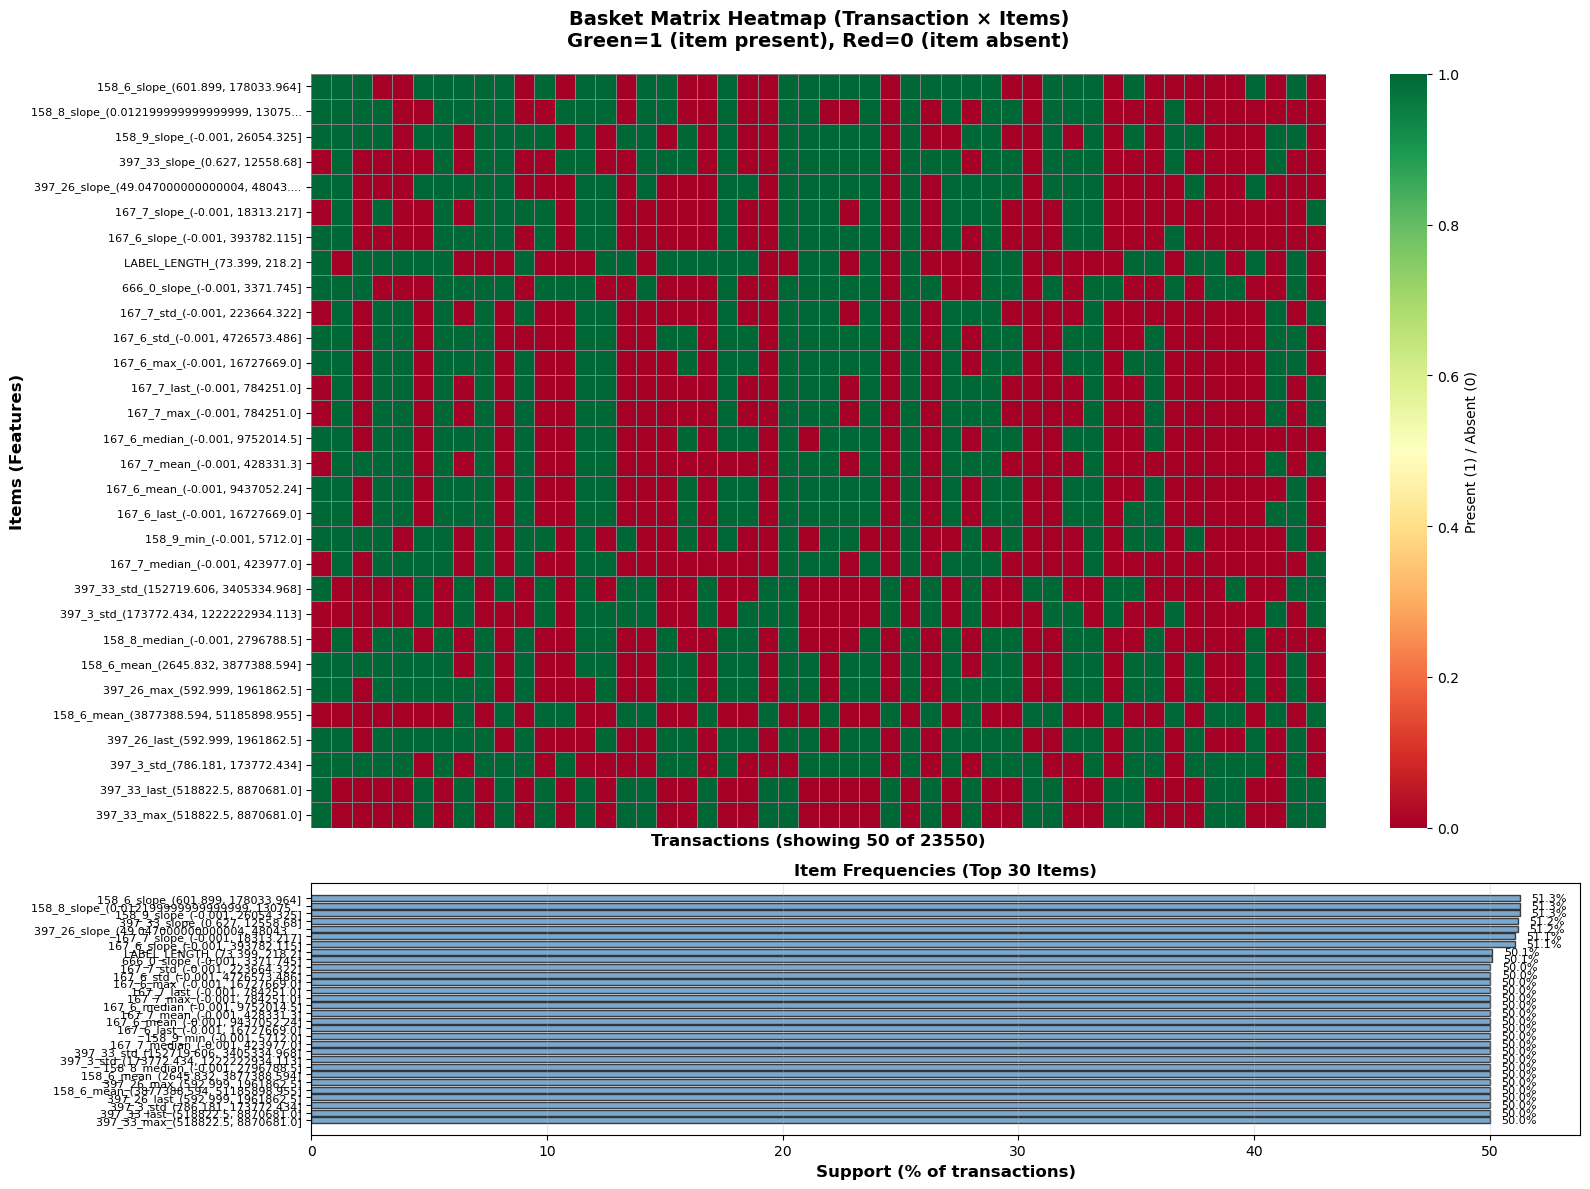


BASKET MATRIX SUMMARY
 Total transactions (vehicles): 23,550
 Total items (features): 103
 Sparsity: 50.39%
 Average items per transaction: 51.1
 Most frequent item: 158_6_slope_(601.899, 178033.964] (51.3%)

 Displaying: 50 transactions × 30 most frequent items


In [23]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use the basket created for association rules
if 'basket' in globals() or 'basket_bool' in globals():
    # Use basket_bool if available, otherwise basket
    basket_data = basket_bool if 'basket_bool' in globals() else basket
    
    # Sample for visualization (too many items to show all)
    n_transactions = min(50, len(basket_data))  # Show 50 transactions
    n_items = min(30, basket_data.shape[1])     # Show 30 items
    
    # Select most frequent items for better visualization
    item_frequencies = basket_data.sum(axis=0).sort_values(ascending=False)
    top_items = item_frequencies.head(n_items).index.tolist()
    
    # Sample transactions
    sample_basket = basket_data[top_items].sample(n=n_transactions, random_state=42)
    
    # Convert to int for better display
    sample_basket_int = sample_basket.astype(int)
    
    # Create figure with larger size
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})
    
    # Main heatmap
    sns.heatmap(sample_basket_int.T, cmap='RdYlGn', cbar_kws={'label': 'Present (1) / Absent (0)'},
                linewidths=0.5, linecolor='gray', ax=ax1, vmin=0, vmax=1,
                xticklabels=False, yticklabels=True)
    
    ax1.set_title('Basket Matrix Heatmap (Transaction × Items)\nGreen=1 (item present), Red=0 (item absent)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel(f'Transactions (showing {n_transactions} of {len(basket_data)})', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Items (Features)', fontsize=12, fontweight='bold')
    
    # Shorten y-tick labels for readability
    yticklabels = [label.get_text()[:40] + '...' if len(label.get_text()) > 40 else label.get_text() 
                   for label in ax1.get_yticklabels()]
    ax1.set_yticklabels(yticklabels, fontsize=8)
    
    # Item frequency bar chart
    item_freq_pct = (item_frequencies.head(n_items) / len(basket_data)) * 100
    ax2.barh(range(len(item_freq_pct)), item_freq_pct.values, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(item_freq_pct)))
    ax2.set_yticklabels([label[:40] + '...' if len(label) > 40 else label for label in item_freq_pct.index], 
                        fontsize=8)
    ax2.set_xlabel('Support (% of transactions)', fontsize=12, fontweight='bold')
    ax2.set_title('Item Frequencies (Top 30 Items)', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.invert_yaxis()
    
    # Add percentage labels
    for i, v in enumerate(item_freq_pct.values):
        ax2.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*60)
    print("BASKET MATRIX SUMMARY")
    print("="*60)
    print(f" Total transactions (vehicles): {len(basket_data):,}")
    print(f" Total items (features): {basket_data.shape[1]:,}")
    print(f" Sparsity: {(1 - basket_data.sum().sum() / (basket_data.shape[0] * basket_data.shape[1])):.2%}")
    print(f" Average items per transaction: {basket_data.sum(axis=1).mean():.1f}")
    print(f" Most frequent item: {item_frequencies.index[0]} ({item_frequencies.values[0]/len(basket_data):.1%})")
    print(f"\n Displaying: {n_transactions} transactions × {n_items} most frequent items")
    
else:
    print(" Basket matrix not found. Please run the association rules cell first.")

## ENHANCED NETWORK VISUALIZATION OF ASSOCIATION RULES

ASSOCIATION RULE NETWORK VISUALIZATION
✓ Graph created with 14 nodes and 12 edges
  • Feature nodes (predictors): 12
  • Label nodes (predictions): 2


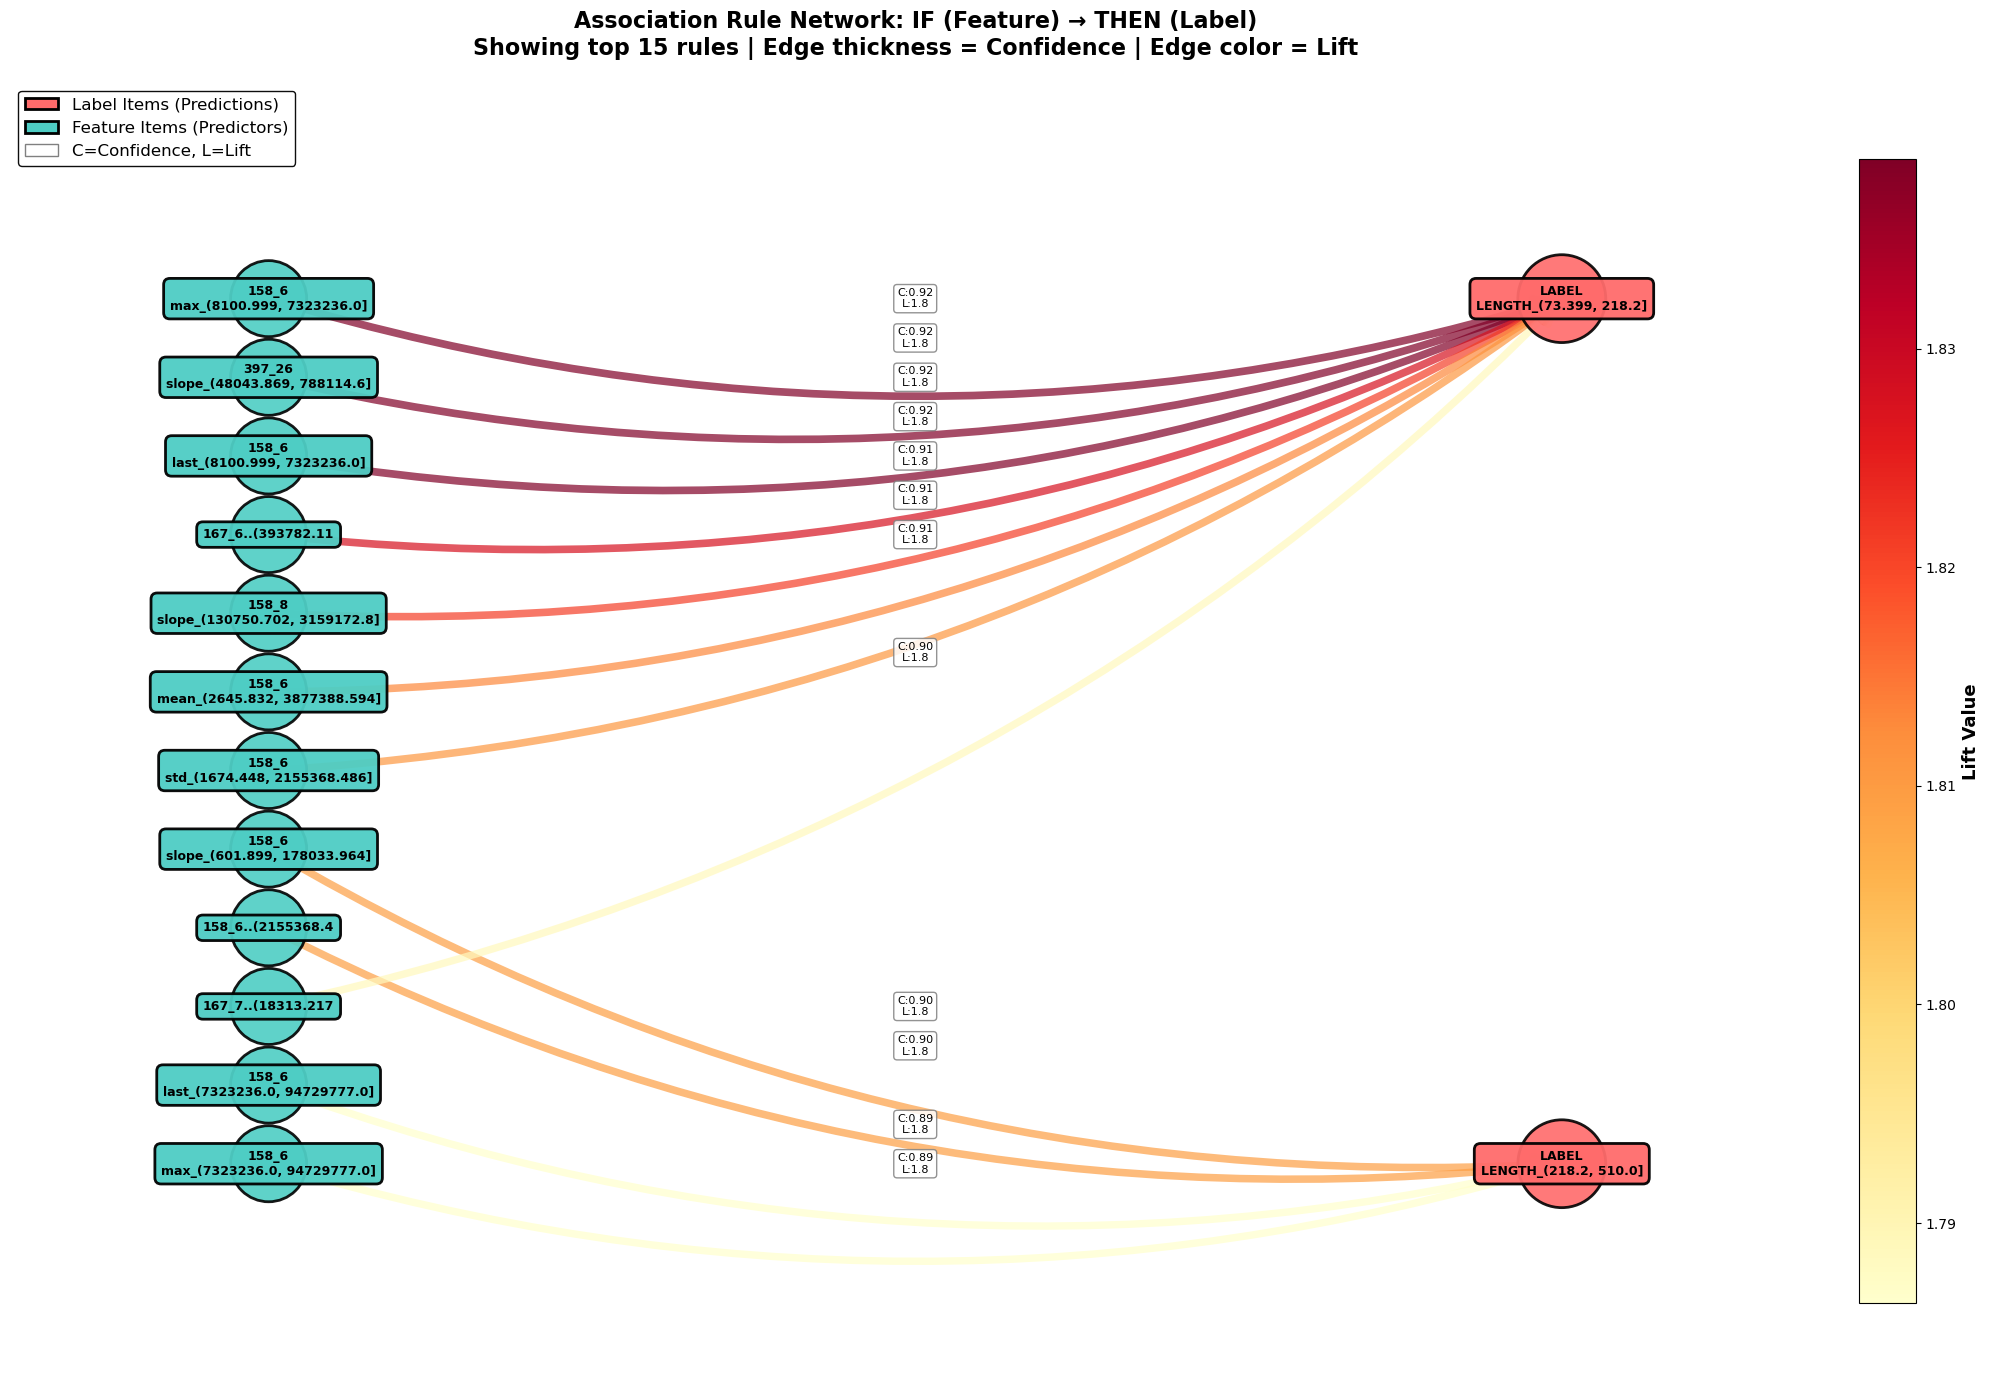


 VISUALIZATION GUIDE
 RED nodes     = Label items (what we're predicting)
 TEAL nodes    = Feature items (what predicts the labels)
 Edge thickness = Confidence (thicker = higher confidence)
 Edge color    = Lift (darker/redder = stronger association)
  Arrow         = Direction of rule (IF feature → THEN label)

 INTERPRETATION:
   • Confidence: Probability that the rule is correct
   • Lift > 1: The rule performs better than random chance
   • Lift > 1.5: Strong positive association
   • Lift > 2: Very strong positive association


In [25]:
# (IF → THEN relationships)

import matplotlib.pyplot as plt
import numpy as np

if 'rules' in globals() and len(rules) > 0:
    try:
        import networkx as nx
        from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
        import matplotlib.patches as mpatches
        
        print("=" * 80)
        print("ASSOCIATION RULE NETWORK VISUALIZATION")
        print("=" * 80)
        
        # Select top rules for visualization
        n_rules = min(15, len(rules))
        top_rules = rules.nlargest(n_rules, 'lift').copy()
        
        # Create directed graph
        G = nx.DiGraph()
        
        # Helper function to convert sets to tuples
        def to_tuple(x):
            if isinstance(x, (set, frozenset)):
                return tuple(sorted(x))
            if hasattr(x, "tolist"):
                return tuple(sorted(x.tolist()))
            if isinstance(x, (tuple, list)):
                return tuple(sorted(x)) if isinstance(x, list) else x
            return (str(x),)
        
        # Helper to shorten labels
        def shorten_label(s, max_len=35):
            if len(s) <= max_len:
                return s
            parts = s.split('_')
            if len(parts) > 3:
                return f"{parts[0]}_{parts[1]}..{parts[-1][:10]}"
            return s[:max_len-3] + "..."
        
        # Build graph
        edge_data = []
        node_labels = {}
        
        for _, row in top_rules.iterrows():
            antecedents = to_tuple(row.get("antecedents", row.get("antecedent")))
            consequents = to_tuple(row.get("consequents", row.get("consequent")))
            conf = float(row["confidence"])
            lift_val = float(row["lift"]) if not np.isnan(row["lift"]) else 1.0
            supp = float(row["support"])
            
            for ant in antecedents:
                for cons in consequents:
                    # Track edge with highest confidence if duplicate
                    if G.has_edge(ant, cons):
                        if conf > G[ant][cons]['confidence']:
                            G[ant][cons]['confidence'] = conf
                            G[ant][cons]['lift'] = lift_val
                            G[ant][cons]['support'] = supp
                    else:
                        G.add_edge(ant, cons, confidence=conf, lift=lift_val, support=supp)
                        edge_data.append({'from': ant, 'to': cons, 'conf': conf, 'lift': lift_val})
                    
                    # Store shortened labels
                    node_labels[ant] = shorten_label(str(ant))
                    node_labels[cons] = shorten_label(str(cons))
        
        # Separate label and feature nodes
        label_nodes = [n for n in G.nodes() if 'LABEL_' in str(n)]
        feature_nodes = [n for n in G.nodes() if 'LABEL_' not in str(n)]
        
        print(f"✓ Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        print(f"  • Feature nodes (predictors): {len(feature_nodes)}")
        print(f"  • Label nodes (predictions): {len(label_nodes)}")
        
        # Create layout
        fig, ax = plt.subplots(figsize=(20, 14))
        
        # Custom hierarchical layout: labels on right, features on left
        pos = {}
        if label_nodes and feature_nodes:
            # Right side: label nodes
            y_step_labels = 2.0 / max(1, len(label_nodes) - 1) if len(label_nodes) > 1 else 0
            for i, node in enumerate(label_nodes):
                y_pos = 1.0 - (i * y_step_labels) if len(label_nodes) > 1 else 0
                pos[node] = (2.0, y_pos)
            
            # Left side: feature nodes
            y_step_features = 2.0 / max(1, len(feature_nodes) - 1) if len(feature_nodes) > 1 else 0
            for i, node in enumerate(feature_nodes):
                y_pos = 1.0 - (i * y_step_features) if len(feature_nodes) > 1 else 0
                pos[node] = (-2.0, y_pos)
        else:
            # Fallback to spring layout
            pos = nx.spring_layout(G, seed=42, k=3, iterations=100)
        
        # Node colors
        node_colors = ['#ff6b6b' if 'LABEL_' in str(n) else '#4ecdc4' for n in G.nodes()]
        node_sizes = [4000 if 'LABEL_' in str(n) else 3000 for n in G.nodes()]
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes,
                              alpha=0.9, ax=ax, node_shape='o', edgecolors='black', linewidths=2)
        
        # Draw edges with varying styles based on metrics
        edges = G.edges()
        
        # Normalize metrics for visualization
        confidences = [G[u][v]['confidence'] for u, v in edges]
        lifts = [G[u][v]['lift'] for u, v in edges]
        
        # Edge width based on confidence (scaled)
        edge_widths = [c * 6 for c in confidences]  # Scale for visibility
        
        # Edge color based on lift
        import matplotlib.cm as cm
        import matplotlib.colors as mcolors
        
        norm = mcolors.Normalize(vmin=min(lifts), vmax=max(lifts))
        cmap = cm.YlOrRd
        edge_colors = [cmap(norm(lift)) for lift in lifts]
        
        # Draw edges
        for (u, v), width, color, conf, lift in zip(edges, edge_widths, edge_colors, confidences, lifts):
            arrow = FancyArrowPatch(
                pos[u], pos[v],
                arrowstyle='-|>',
                connectionstyle='arc3,rad=0.15',
                linewidth=width,
                color=color,
                alpha=0.7,
                mutation_scale=30,
                zorder=1
            )
            ax.add_patch(arrow)
        
        # Draw node labels with better formatting
        for node, (x, y) in pos.items():
            label = node_labels[node]
            
            # Wrap long labels
            if len(label) > 25:
                words = label.split('_')
                if len(words) > 2:
                    mid = len(words) // 2
                    label = '_'.join(words[:mid]) + '\n' + '_'.join(words[mid:])
            
            # Determine color
            is_label = 'LABEL_' in str(node)
            bg_color = '#ff6b6b' if is_label else '#4ecdc4'
            
            # Draw text box
            ax.text(x, y, label, fontsize=9, fontweight='bold',
                   ha='center', va='center', zorder=3,
                   bbox=dict(boxstyle='round,pad=0.5', 
                           facecolor=bg_color,
                           edgecolor='black',
                           linewidth=2,
                           alpha=0.95))
        
        # Add edge labels (confidence and lift)
        edge_labels = {}
        for u, v, d in G.edges(data=True):
            mid_x = (pos[u][0] + pos[v][0]) / 2
            mid_y = (pos[u][1] + pos[v][1]) / 2
            
            label_text = f"C:{d['confidence']:.2f}\nL:{d['lift']:.1f}"
            ax.text(mid_x, mid_y, label_text, fontsize=8,
                   ha='center', va='center', zorder=2,
                   bbox=dict(boxstyle='round,pad=0.3', 
                           facecolor='white',
                           edgecolor='gray',
                           alpha=0.85))
        
        # Add colorbar for lift values
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
        cbar.set_label('Lift Value', fontsize=13, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
        
        # Add legend
        legend_elements = [
            mpatches.Patch(facecolor='#ff6b6b', edgecolor='black', label='Label Items (Predictions)', linewidth=2),
            mpatches.Patch(facecolor='#4ecdc4', edgecolor='black', label='Feature Items (Predictors)', linewidth=2),
            mpatches.Patch(facecolor='white', edgecolor='gray', label='C=Confidence, L=Lift', linewidth=1)
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=12, 
                 framealpha=0.95, edgecolor='black', fancybox=True)
        
        # Title and formatting
        plt.title("Association Rule Network: IF (Feature) → THEN (Label)\n" +
                 f"Showing top {n_rules} rules | Edge thickness = Confidence | Edge color = Lift",
                 fontsize=16, fontweight='bold', pad=20)
        
        ax.set_xlim(-2.8, 2.8)
        ax.set_ylim(-1.5, 1.5)
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print interpretation guide
        print("\n" + "="*80)
        print(" VISUALIZATION GUIDE")
        print("="*80)
        print(" RED nodes     = Label items (what we're predicting)")
        print(" TEAL nodes    = Feature items (what predicts the labels)")
        print(" Edge thickness = Confidence (thicker = higher confidence)")
        print(" Edge color    = Lift (darker/redder = stronger association)")
        print("  Arrow         = Direction of rule (IF feature → THEN label)")
        print("\n INTERPRETATION:")
        print("   • Confidence: Probability that the rule is correct")
        print("   • Lift > 1: The rule performs better than random chance")
        print("   • Lift > 1.5: Strong positive association")
        print("   • Lift > 2: Very strong positive association")
        print("="*80)
        
    except ImportError:
        print(" NetworkX is required for network visualization.")
        print("  Install with: pip install networkx")
    except Exception as e:
        print(f" Network visualization failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print(" No association rules found. Please run the association rules mining cell first.")